# Practical Exam WS24/25
# Introduction to Scientific Machine Learning

First name: Ravell

Last name: Revano

Matr. Nr.: 03752644

---

**Task: Heat Exchanger Control**

[46 Pts] You work in a company manufacturing heat exchangers, and your task is to help customers estimate the risk of damaging their goods by letting too low or high temperatures pass through. We assume to have access to a heat exchanger-specific dataset of system states $((x_t,y_t) | t \in \{1,...,T\})$, where $x_t\in \mathbb{R}$ is the target outflow temperature at time $t$, $y_t\in \mathbb{R}$ is the measured outflow temperature, and $T$ is the number of discrete time steps per measurement sequence. The given dataset consists of $M=8$ trajectories of variable length $T_i$, each of which captures the response to a different type of target profile, e.g., stepwise, sinusoidal, etc. Sequences 0-5 will be used for training, sequence 6 for validation, and sequence 7 for testing.

Your task is to first design a data-driven predictive model $f$ for the outflow temperature $y_t=f(x_{(t-N+1):t})$, where the input sequence $x_{(t-N+1):t}$ of length $N=50$ is needed to account for transient effects. Subsequently, you will extend this model to provide the 5th and 95th percentiles of the predicted outflow temperature.

Note on the dataset: If trajectory $i$ has length $T_i=1000$ and we use $N=50$ inputs, then we can generate $T_i-N+1=951$ training examples from it. 

---

### 1. [10 Pts] Baseline Method

  Propose two simple models that can be used to solve this task and explain how. Implement one of them using pure Pytorch (i.e., only `nn.Linear`), train it, and report its performance qualitatively\* and quantitatively\*\*.

### 2. [8 Pts] Deep Learning Model

  Implement, train, and evaluate (qualitatively and quantitatively) a deep learning model to solve the same task. Again use only `nn.Linear`.

### 3. [10 Pts] Model Improvements

  Using your deep learning model, argue which 4 approaches for performance improvement discussed in the lecture promise to be beneficial in this setup. For each of them, retrain the model and document its performance quantitatively. Discuss the results, and if the performance drops after some of these modifications, explain why this might happen.

### 4. [18 Pts] Confidence Bounds

  Extend your deep learning algorithm from the previous task to account for parameter uncertainties. In this task, you are not limited to pure Pytorch. Fit and use this model to run autoregressive inference on the full test sequence. Then, evaluate the 5th and 95th percentiles of the prediction, i.e., the bandgap of solutions over time. Lastly, plot the outflow temperature distribution on the test sequence at $t=400$.

> \*qualitatively = with a full rollout visualization; \*\*quantitatively = with a number

> Tuning hyperparameters is not the core of these tasks. However, you should demonstrate somewhat plausible results.

*Good luck in the exam!*

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset

# Add all necessary imports here
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F
%pip install pyro-ppl
import pyro
import pyro.distributions as dist


: 

## 0. Data Visualization and Pre-processing

First we visualize the sequences.

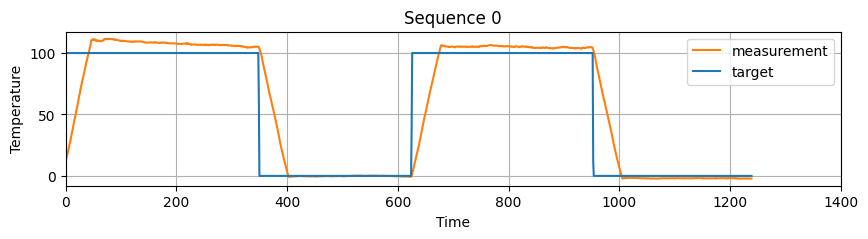

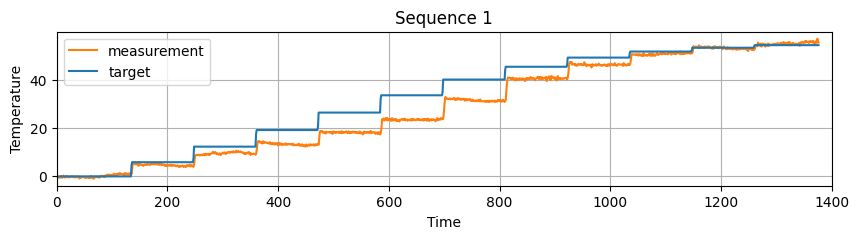

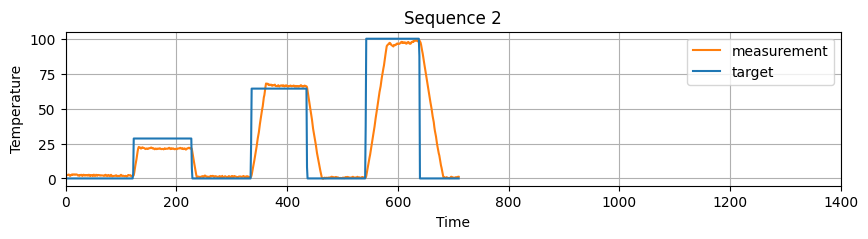

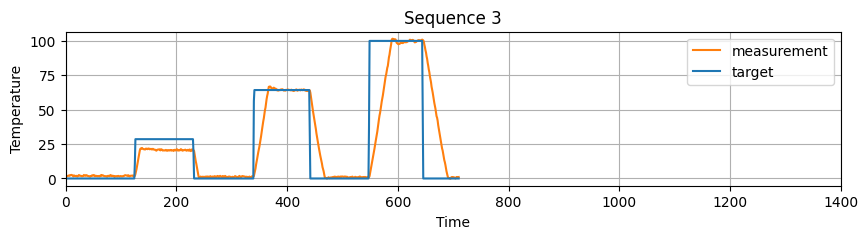

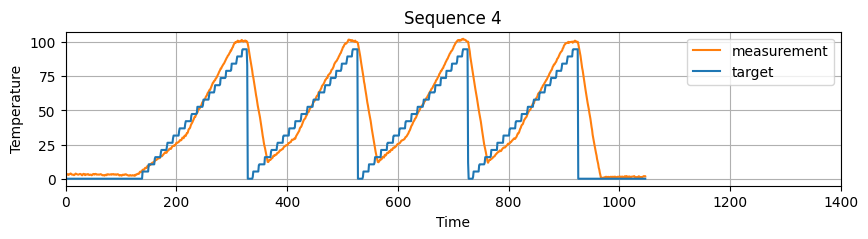

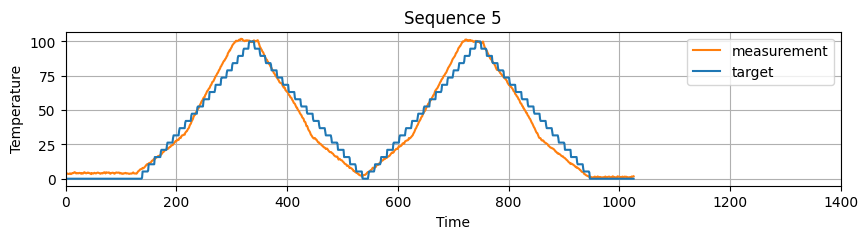

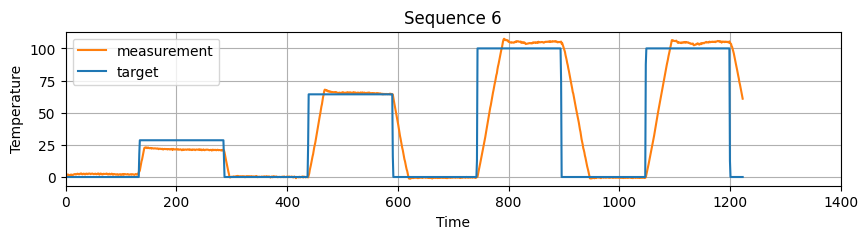

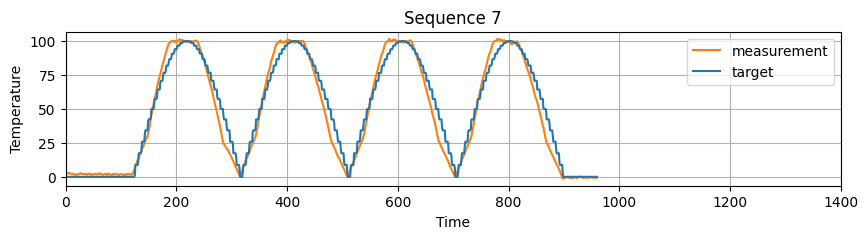

In [2]:
# ! unzip dataset.zip 

for i in range(8):
    df = pd.read_csv(f'dataset/sequence_{i}.csv')
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()

    plt.figure(figsize=(10, 2))
    plt.plot(y, "C1", label="measurement")
    plt.plot(x, "C0", label="target")
    plt.legend()
    plt.title(f"Sequence {i}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.xlim(0, 1400)
    plt.grid()
    plt.show()

Dataset class.

In [3]:
class CreateTrajectoryDataset(Dataset):
    def __init__(self, data_path, split, seq_length):
        self.seq_length = seq_length
        self.data = []

        files = os.listdir(data_path)
        files.sort()

        if split == "train":
            files = files[:6]  # Sequences 0-5
        elif split == "val":
            files = files[6:7]  # Sequence 6
        elif split == "test":
            files = files[7:8]  # Sequence 7

        for file_i in files:
            df = pd.read_csv(os.path.join(data_path, file_i))
            X = df["x"].to_numpy()
            Y = df["y"].to_numpy()
            T = len(X)
            
            for start_idx in range(T - seq_length + 1):
                X_sub = X[start_idx : start_idx + seq_length]
                Y_sub = Y[start_idx + seq_length - 1, None]
                self.data.append((X_sub, Y_sub))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """ Slice a window of the time series.
        
        Returns a pair of: 
            - Input sequence [x_{t-seq_length+1}, ..., x_{t-1}, x_t].
            - Corresponding target y_t.
        """
        X_seq, Y_seq = self.data[idx]
        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(Y_seq, dtype=torch.float32)


train_dataset = CreateTrajectoryDataset(data_path="dataset", split="train", seq_length=50)

print(f"Number of training examples: {len(train_dataset)}")
example_x, example_y = train_dataset[0]
print(f"Shape of a training example: {example_x.shape}, {example_y.shape}")

Number of training examples: 5820
Shape of a training example: torch.Size([50]), torch.Size([1])


## 1. Baseline Method

In [4]:
# Your code here
"""
There are two models which can be used to solve this problem: 

- Linear Regression model, you would need to do the following steps:
1. Prepare the dataset 
2. Define the model with only using PyTorch with a single linear layer (nn.Linear(input_dim=N,output_dim=1))
3. Load the data, and initialize the model
4. Train the model for a certain number of epochs
5. Evaluate and report the performance qualitatively and quantitatively

- Moving Average model (though I believe we did not cover this in the Vorlesung), you would need to do the following steps:
  1. Prepare the dataset
  2. Define the model to compute the moving average over a specified window size (e.g., using a simple convolution or rolling mean)
  3. Load the data, and initialize the model
  4. Apply the moving average formula to the data for prediction
  5. Evaluate and report the performance qualitatively and quantitatively

"""
# Get the data
for i in range(6):
    df = pd.read_csv(f'dataset/sequence_{i}.csv')
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    
    exec(f'x_{i} = x')  # Create x_0, x_1, ..., x_5
    exec(f'y_{i} = y')  # Create y_0, y_1, ..., y_5

print(x_0.shape, x_1.shape, x_2.shape, x_3.shape, x_4.shape, x_5.shape)
print(y_0.shape, y_1.shape, y_2.shape, y_3.shape, y_4.shape, y_5.shape)

x_all = np.concatenate([x_0, x_1, x_2, x_3, x_4, x_5])
y_all = np.concatenate([y_0, y_1, y_2, y_3, y_4, y_5])

print(x_all.shape, y_all.shape)

seed = 8 # Set seed for reproducibility
torch.manual_seed(seed)

T = len(x_all)
N = 50 # Sliding window size

X_train = np.array([x_all[i:i+N] for i in range(T-N)])
y_train = y_all[N:]

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Implementation of Linear Regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, N=50):
        super(LinearRegressionModel, self).__init__()  
        self.linear = nn.Linear(N, 1)  # N is the input sequence, which has length 50

    def forward(self, x):
        out = self.linear(x)  
        return out  

learning_rate = 0.01
epochs = 100
lin_model = LinearRegressionModel(N) # Initialize the model 
criterion = nn.MSELoss() # Loss function
optimizer = torch.optim.Adam(lin_model.parameters(), lr=learning_rate) # optimizer, here I use Adam

# Training
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = lin_model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item())) 

with torch.no_grad():  
    predicted = lin_model(X_train_torch).numpy() 

print(predicted)

plt.clf()
plt.plot(y_train, 'go', label='True data')
plt.plot(predicted, '.', label='Predictions')
plt.legend()
plt.grid()
plt.show()

# Load validation & test sequences
df_val = pd.read_csv('dataset/sequence_6.csv')
df_test = pd.read_csv('dataset/sequence_7.csv')

x_val, y_val = df_val["x"].to_numpy(), df_val["y"].to_numpy()
x_test, y_test = df_test["x"].to_numpy(), df_test["y"].to_numpy()

T_val, T_test = len(x_val), len(x_test) # From the sliding window inputs

X_val = np.array([x_val[i:i+N] for i in range(T_val-N)])
y_val = y_val[N:]

X_test = np.array([x_test[i:i+N] for i in range(T_test-N)])
y_test = y_test[N:]

# Convert to PyTorch tensors
X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Evaluate the model
with torch.no_grad():
    y_val_pred = lin_model(X_val_torch).numpy()
    y_test_pred = lin_model(X_test_torch).numpy()

# Qualitative evaluation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(y_val, 'go', label='True Validation Data')
plt.plot(y_val_pred, 'r.', label='Validation Predictions')
plt.title("Validation Set")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(y_test, 'bo', label='True Test Data')
plt.plot(y_test_pred, 'r.', label='Test Predictions')
plt.title("Test Set")
plt.legend()
plt.grid()
plt.show()

# Quantitative evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Validation MSE: {mse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test MSE: {mse_test:.4f}, MAE: {mae_test:.4f}")

## 2. Deep Learning Model

In [5]:
# Your code here
for i in range(6):
    df = pd.read_csv(f'dataset/sequence_{i}.csv')
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    
    exec(f'x_{i} = x')  # Create x_0, x_1, ..., x_5
    exec(f'y_{i} = y')  # Create y_0, y_1, ..., y_5

print(x_0.shape, x_1.shape, x_2.shape, x_3.shape, x_4.shape, x_5.shape)
print(y_0.shape, y_1.shape, y_2.shape, y_3.shape, y_4.shape, y_5.shape)

x_all = np.concatenate([x_0, x_1, x_2, x_3, x_4, x_5])
y_all = np.concatenate([y_0, y_1, y_2, y_3, y_4, y_5])

print(x_all.shape, y_all.shape)

seed = 8 # Set seed for reproducibility
torch.manual_seed(seed)

T = len(x_all)
N = 50 # Sliding window size

X_train = np.array([x_all[i:i+N] for i in range(T-N)])
y_train = y_all[N:]

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# I will be using CNN

class CNNModel(nn.Module):
    def __init__(self, N=50):
        super().__init__()
        self.fc1 = nn.Linear(N,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,1)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

learning_rate = 0.01
epochs = 100
c_model = CNNModel(N)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(c_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = c_model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

# Prediction
with torch.no_grad():
    predicted = c_model(X_train_torch).numpy()

print(predicted)

plt.clf()
plt.plot(y_train, 'go', label='True data')
plt.plot(predicted, '.', label='Predictions')
plt.legend()
plt.grid()
plt.show()

# Load validation & test sequences
df_val = pd.read_csv('dataset/sequence_6.csv')
df_test = pd.read_csv('dataset/sequence_7.csv')

x_val, y_val = df_val["x"].to_numpy(), df_val["y"].to_numpy()
x_test, y_test = df_test["x"].to_numpy(), df_test["y"].to_numpy()

T_val, T_test = len(x_val), len(x_test)  # Lengths of validation and test sequences

# Sliding window to match the input sequence of length N
X_val = np.array([x_val[i:i+N] for i in range(T_val-N)])
y_val = y_val[N:]

X_test = np.array([x_test[i:i+N] for i in range(T_test-N)])
y_test = y_test[N:]

# Convert to PyTorch tensors
X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Evaluate the CNN model
with torch.no_grad():
    # Predict on validation and test data using the trained CNN model (c_model)
    y_val_pred = c_model(X_val_torch).numpy()
    y_test_pred = c_model(X_test_torch).numpy()

# Qualitative evaluation

plt.figure(figsize=(12, 5))

# Validation data visualization
plt.subplot(1, 2, 1)
plt.plot(y_val, 'go', label='True Validation Data')
plt.plot(y_val_pred, 'r.', label='Validation Predictions')
plt.title("Validation Set")
plt.legend()
plt.grid()

# Test data visualization
plt.subplot(1, 2, 2)
plt.plot(y_test, 'bo', label='True Test Data')
plt.plot(y_test_pred, 'r.', label='Test Predictions')
plt.title("Test Set")
plt.legend()
plt.grid()

plt.show()

# Quantitative evaluation

# Mean Squared Error and Mean Absolute Error for validation and test sets
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"\nValidation MSE: {mse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test MSE: {mse_test:.4f}, MAE: {mae_test:.4f}")
print(f'Final Training Loss: {loss.item()}')

# Take the final training loss to compare to the optimization models
c_model_final_loss = loss.item()

## 3. Model Improvements

In [6]:
# Your code here
from sklearn.metrics import mean_absolute_error, mean_squared_error

torch.manual_seed(5)

"""
I will first load the data again, then implement the changes under each approach
"""
def prepare_data(window_size=50):
    # Load training data
    x_all, y_all = [], []
    for i in range(6):
        df = pd.read_csv(f'dataset/sequence_{i}.csv')
        x_all.append(df["x"].to_numpy())
        y_all.append(df["y"].to_numpy())
    
    x_all = np.concatenate(x_all)
    y_all = np.concatenate(y_all)

    # Sliding window setup for training
    T = len(x_all)
    X_train = np.array([x_all[i:i+window_size] for i in range(T-window_size)])
    y_train = y_all[window_size:]

    # Convert to PyTorch tensors
    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    # Load val data
    df_val = pd.read_csv('dataset/sequence_6.csv')
    x_val, y_val = df_val["x"].to_numpy(), df_val["y"].to_numpy()
    T_val = len(x_val)
    
    # Sliding window val
    X_val = np.array([x_val[i:i+window_size] for i in range(T_val-window_size)])
    y_val = y_val[window_size:]

    # Convert to PyTorch tensors
    X_val_torch = torch.tensor(X_val, dtype=torch.float32)
    y_val_torch = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Load test data
    df_test = pd.read_csv('dataset/sequence_7.csv')
    x_test, y_test = df_test["x"].to_numpy(), df_test["y"].to_numpy()
    T_test = len(x_test)
    
    # Sliding window test
    X_test = np.array([x_test[i:i+window_size] for i in range(T_test-window_size)])
    y_test = y_test[window_size:]

    # Convert to PyTorch tensors
    X_test_torch = torch.tensor(X_test, dtype=torch.float32)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    return X_train_torch, y_train_torch, X_val_torch, y_val_torch, X_test_torch, y_test_torch



#
# Approach 1: Learning rate scheduling using MultiStepLR (from the Exercise)
#
X_train_torch, y_train_torch, X_val_torch, y_val_torch, X_test_torch, y_test_torch = prepare_data(window_size=50)

import torch.optim.lr_scheduler as lr_scheduler

# CNN Model Definition
class CNNModel1(nn.Module):
    def __init__(self, N=50):
        super().__init__()
        self.fc1 = nn.Linear(N, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

learning_rate = 0.01
c1_model = CNNModel1(N)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(c1_model.parameters(), lr=learning_rate)

scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.7) 

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = c1_model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Update learning rate with scheduler
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]["lr"]}')

# Evaluate the model
with torch.no_grad():
    y_train_pred = c1_model(X_train_torch).numpy()
    y_val_pred = c1_model(X_val_torch).numpy()
    y_test_pred = c1_model(X_test_torch).numpy()

train_mae = mean_absolute_error(y_train_torch.numpy(), y_train_pred)
val_mae = mean_absolute_error(y_val_torch.numpy(), y_val_pred)
test_mae = mean_absolute_error(y_test_torch.numpy(), y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train_torch.numpy(), y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_torch.numpy(), y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_torch.numpy(), y_test_pred))

print(f'Final Training Loss approach 1: {loss.item()}')
print(f'Final Learning Rate applied approach 1: {optimizer.param_groups[0]["lr"]}')
print(f'Training MAE approach 1: {train_mae:.4f}, RMSE approach 1: {train_rmse:.4f}')
print(f'Validation MAE approach 1: {val_mae:.4f}, RMSE approach 1: {val_rmse:.4f}')
print(f'Test MAE approach 1: {test_mae:.4f}, RMSE approach 1: {test_rmse:.4f}')

c1_model_final_loss = loss.item()

#
# Approach 2: Regularization (L1 and L2)
#

X_train_torch, y_train_torch, X_val_torch, y_val_torch, X_test_torch, y_test_torch = prepare_data(window_size=50)

# CNN Model Definition
class CNNModel2(nn.Module):
    def __init__(self, N=50):
        super().__init__()
        self.fc1 = nn.Linear(N, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def l1_reg(model):
    return sum(torch.norm(p, 1) for p in model.parameters())

def l2_reg(model):
    return sum(torch.norm(p, 2) for p in model.parameters())

reg_lambda = 0.05
epochs = 100
learning_rate = 0.01
c2_model = CNNModel2(N)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(c2_model.parameters(), lr= learning_rate)

# Training loop with regularization
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = c2_model(X_train_torch)
    
    # Apply both L1 and L2 regularization
    loss = criterion(y_pred, y_train_torch) \
           + reg_lambda * l1_reg(c2_model) \
           + reg_lambda * l2_reg(c2_model)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluate the model
with torch.no_grad():
    y_train_pred = c2_model(X_train_torch).numpy()
    y_val_pred = c2_model(X_val_torch).numpy()
    y_test_pred = c2_model(X_test_torch).numpy()

# Compute MAE and RMSE
train_mae = mean_absolute_error(y_train_torch.numpy(), y_train_pred)
val_mae = mean_absolute_error(y_val_torch.numpy(), y_val_pred)
test_mae = mean_absolute_error(y_test_torch.numpy(), y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train_torch.numpy(), y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_torch.numpy(), y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_torch.numpy(), y_test_pred))

print(f'Final Training Loss approach 2: {loss.item()}')
print(f'Training MAE approach 2: {train_mae:.4f}, RMSE approach 2: {train_rmse:.4f}')
print(f'Validation MAE approach 2: {val_mae:.4f}, RMSE approach 2: {val_rmse:.4f}')
print(f'Test MAE approach 2: {test_mae:.4f}, RMSE approach 2: {test_rmse:.4f}')
print("Regularization applied.")

c2_model_final_loss = loss.item()


#
# Approach 3: Other hyperparameter tuning
#
# change epoch, learning rate, change loss function and optimizer, use different hidden sizes and/or add layers

X_train_torch, y_train_torch, X_val_torch, y_val_torch, X_test_torch, y_test_torch = prepare_data(window_size=50)

# CNN Model Definition + some changes
class CNNModel3(nn.Module):
    def __init__(self, N=50):
        super().__init__()
        self.fc1 = nn.Linear(N, 64) # Increased number of neurons
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1) # Added hidden layer
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
        
learning_rate = 0.005  # Adjusted learning rate
epochs = 200  # Increased epochs
c3_model = CNNModel3(N)
criterion = nn.L1Loss()  # Changed loss function to L1 Loss
optimizer = torch.optim.SGD(c3_model.parameters(), lr=learning_rate, momentum=0.9)  # Changed optimizer to SGD with momentum

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = c3_model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluate the model
with torch.no_grad():
    y_train_pred = c3_model(X_train_torch).numpy()
    y_val_pred = c3_model(X_val_torch).numpy()
    y_test_pred = c3_model(X_test_torch).numpy()

# Compute MAE and RMSE
train_mae = mean_absolute_error(y_train_torch.numpy(), y_train_pred)
val_mae = mean_absolute_error(y_val_torch.numpy(), y_val_pred)
test_mae = mean_absolute_error(y_test_torch.numpy(), y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train_torch.numpy(), y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_torch.numpy(), y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_torch.numpy(), y_test_pred))

print(f'Final Training Loss approach 3: {loss.item()}')
print(f'Training MAE approach 3: {train_mae:.4f}, RMSE approach 3: {train_rmse:.4f}')
print(f'Validation MAE approach 3: {val_mae:.4f}, RMSE approach 3: {val_rmse:.4f}')
print(f'Test MAE approach 3: {test_mae:.4f}, RMSE approach 3: {test_rmse:.4f}')
print("Regularization applied.")

c3_model_final_loss = loss.item()


#
# Approach 4: Input Normalization and Parameter Initalization
#

X_train_torch, y_train_torch, X_val_torch, y_val_torch, X_test_torch, y_test_torch = prepare_data(window_size=50)

import torch.nn.init as init

# Normalize input data (standardization)
x_mean, x_std = X_train_torch.mean(), X_train_torch.std()
y_mean, y_std = y_train_torch.mean(), y_train_torch.std()

X_train_torch = (X_train_torch - x_mean) / x_std
X_val_torch = (X_val_torch - x_mean) / x_std
X_test_torch = (X_test_torch - x_mean) / x_std

y_train_torch = (y_train_torch - y_mean) / y_std
y_val_torch = (y_val_torch - y_mean) / y_std
y_test_torch = (y_test_torch - y_mean) / y_std

# CNN model with parameter initialization
class CNNModel4(nn.Module):
    def __init__(self, N=50):
        super().__init__()
        self.fc1 = nn.Linear(N, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

learning_rate = 0.01
c4_model = CNNModel4(N)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(c4_model.parameters(), lr=learning_rate)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = c4_model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluate the model
with torch.no_grad():
    y_train_pred = c4_model(X_train_torch).numpy()
    y_val_pred = c4_model(X_val_torch).numpy()
    y_test_pred = c4_model(X_test_torch).numpy()

# Compute MAE and RMSE
train_mae = mean_absolute_error(y_train_torch.numpy(), y_train_pred)
val_mae = mean_absolute_error(y_val_torch.numpy(), y_val_pred)
test_mae = mean_absolute_error(y_test_torch.numpy(), y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train_torch.numpy(), y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_torch.numpy(), y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_torch.numpy(), y_test_pred))

print(f'Final Training Loss approach 4: {loss.item()}')
print(f'Training MAE approach 4: {train_mae:.4f}, RMSE approach 4: {train_rmse:.4f}')
print(f'Validation MAE approach 4: {val_mae:.4f}, RMSE approach 4: {val_rmse:.4f}')
print(f'Test MAE approach 4: {test_mae:.4f}, RMSE approach 4: {test_rmse:.4f}')
print("Input Normalization and Parameter Initialization applied.")

c4_model_final_loss = loss.item()

"""
Explanation of why the performance of the models may drop after the optimization:
1. Learning Rate Scheduling
-> The performance could drop if the learning rate decreases too quickly or too much.
If the learning rate becomes too small during training, the model might stop making
meaningful updates to the weights, which would slow down convergance and potentially 
lead to worse solutions. So, the scheduling should be tuned to avoid the model 
"stopping" prematurely.

2. Regularization
-> If the regulation strength (reg_lambda) is set too high, there could be a drop
in performance. If we over-penalize the model, we prevent it from learning 
useful patterns in the data, which leads to underfitting. 

3. Other hypermarameter tuning
-> There are many parameters to tune, and these parameters are specific for the
dataset which we use it on. If performance drops after the hyperparameter 
changes, then it means that the hyperparameters are not well suited for the 
current dataset. Increasing epochs might lead to overfitting, especially if
the learning rate is not adjusted accordingly. Changing the optimzier or 
loss function might also result in slower convergence or worse results if
they are not well suited for the dataset.

4. Input Normalization and Parameter Initialization
-> If the performance drops after input normalization, then it may be 
because the model wasn't able to adapt to the new, transformed input data. If 
taking the mean and standard deviation was too aggressive or making the data too 
"flat", the model might have difficulties to learn meaningful patterns.
"""

print(f"\nc1, c2, c3, c4 model final training losses compared to c_model:\n "
      f"c1_model_final_loss: {c1_model_final_loss:.4f}\n "
      f"c2_model_final_loss: {c2_model_final_loss:.4f}\n "
      f"c3_model_final_loss: {c3_model_final_loss:.4f}\n "
      f"c4_model_final_loss: {c4_model_final_loss:.4f}\n "
      f"c_model_final_loss: {c_model_final_loss:.4f}")


## 4. Confidence Bounds

In [7]:
# Your code here
torch.manual_seed(8)

# Load training data
x_all, y_all = [], []
for i in range(6):
    df = pd.read_csv(f'dataset/sequence_{i}.csv')
    x_all.append(df["x"].to_numpy())
    y_all.append(df["y"].to_numpy())

x_all = np.concatenate(x_all)
y_all = np.concatenate(y_all)

T = len(x_all)
window_size = 50  # Ensure this is defined
X_train = np.array([x_all[i:i+window_size] for i in range(T-window_size)])
y_train = y_all[window_size:]

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Load validation data
df_val = pd.read_csv('dataset/sequence_6.csv')
x_val, y_val = df_val["x"].to_numpy(), df_val["y"].to_numpy()
T_val = len(x_val)

# Sliding window val
X_val = np.array([x_val[i:i+window_size] for i in range(T_val-window_size)])
y_val = y_val[window_size:]

# Convert to PyTorch tensors
X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Load test data
df_test = pd.read_csv('dataset/sequence_7.csv')
x_test, y_test = df_test["x"].to_numpy(), df_test["y"].to_numpy()
T_test = len(x_test)

# Sliding window test
X_test = np.array([x_test[i:i+window_size] for i in range(T_test-window_size)])
y_test = y_test[window_size:]

# Convert to PyTorch tensors
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class BayesianCNN(nn.Module):
    def __init__(self, N=50, dropout_rate=0.2):
        super(BayesianCNN, self).__init__()
        self.fc1 = nn.Linear(N, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout_rate = dropout_rate
    
    def forward(self, x, apply_dropout=True):
        x = F.relu(self.fc1(x))
        if apply_dropout:
            x = F.dropout(x, p=self.dropout_rate, training=True)
        x = F.relu(self.fc2(x))
        if apply_dropout:
            x = F.dropout(x, p=self.dropout_rate, training=True)
        x = F.relu(self.fc3(x))
        if apply_dropout:
            x = F.dropout(x, p=self.dropout_rate, training=True)
        x = self.fc4(x)
        return x

# Perform autoregressive inference with uncertainty 
def autoregressive_inference_with_uncertainty(model, X_input, n_steps, num_samples=100):
    model.eval()  
    all_preds = []
    
    # Run multiple stochastic passes to estimate uncertainty
    for _ in range(num_samples):
        preds = []
        current_input = X_input.clone()

        # Make predictions for the next `n_steps`
        for _ in range(n_steps):
            with torch.no_grad():
                pred = model(current_input, apply_dropout=True)
                preds.append(pred)
                # Update the input for the next prediction (autoregressive)
                current_input = torch.cat([current_input[:, 1:], pred], dim=1)
        
        all_preds.append(torch.stack(preds, dim=1))  # Stack all predictions for percentile estimation
    
    # Compute the 5th and 95th percentiles for each time step
    all_preds = torch.stack(all_preds, dim=0)  # Shape: [num_samples, n_steps]
    percentiles_5th = torch.quantile(all_preds, 0.05, dim=0)  # Use quantile for earlier PyTorch versions
    percentiles_95th = torch.quantile(all_preds, 0.95, dim=0)
    
    return percentiles_5th, percentiles_95th, all_preds

def train_model(model, X_train, y_train, learning_rate=0.001, epochs=100):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()
        y_pred = model(X_train, apply_dropout=True)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

model = BayesianCNN(N=50, dropout_rate=0.1)
train_model(model, X_train_torch, y_train_torch, learning_rate=0.01, epochs=100)

# Do autoregressive inference on test data
n_steps = 1000  
percentiles_5th, percentiles_95th, all_preds = autoregressive_inference_with_uncertainty(model, X_test_torch, n_steps=n_steps, num_samples=100)

# Squeeze the percentiles tensors to remove extra dimension
percentiles_5th = percentiles_5th.squeeze()  
percentiles_95th = percentiles_95th.squeeze()  

# Reduce the percentiles across the samples
percentiles_5th = torch.quantile(percentiles_5th, 0.05, dim=0)  # Compute the 5th percentile across all samples
percentiles_95th = torch.quantile(percentiles_95th, 0.95, dim=0)  # Compute the 95th percentile across all samples

# Plot the 5th and 95th percentiles
plt.plot(range(n_steps), percentiles_5th.numpy(), label="5th Percentile", color="blue")
plt.plot(range(n_steps), percentiles_95th.numpy(), label="95th Percentile", color="red")
plt.fill_between(range(n_steps), percentiles_5th.numpy(), percentiles_95th.numpy(), color="gray", alpha=0.2)  # Show the difference
plt.title("Prediction Uncertainty (5th-95th Percentiles)")
plt.xlabel("Time Step")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()

test_t = 400

# Get all the predictions at t=400 from the sampled predictions
all_preds_at_400 = all_preds[:, test_t, :].squeeze()  # Shape: (num_samples,)

# Plot the distribution at t=400
plt.figure()  
plt.hist(all_preds_at_400.numpy(), bins=50, alpha=0.7, label='Predicted Distribution at t=400') 
plt.title(f"Distribution of Predictions at t={test_t}")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()